In [39]:
import torch.nn as nn
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from torchvision.transforms import ToTensor, Normalize, Compose

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

#### Creating custom dataset class for CIFAR10
source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

In [40]:
# custom CIFAR10 dataset
class CustomCIFAR(TensorDataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [41]:
cifar_train_data = CIFAR10(root='./CIFAR10', train=True, download=True)
cifar_test_data = CIFAR10(root='./CIFAR10', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
cifar_train_data.data.shape, len(cifar_train_data.targets), cifar_test_data.data.shape, len(cifar_test_data.targets), cifar_train_data.classes

((50000, 32, 32, 3),
 50000,
 (10000, 32, 32, 3),
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

#### Selecting classes `1`, `4`, `8` i.e. automobile, deer, ship for training and testing

In [43]:
train_X = []                                              # for 3 classes                     
train_y = []
for i, j in enumerate(cifar_train_data.targets):
    if j in [1, 4, 8]:
        train_X.append(cifar_train_data.data[i])
        train_y.append(j)

test_X = []                                              # for 3 classes
test_y = []
for i, j in enumerate(cifar_test_data.targets):
    if j in [1, 4, 8]:
        test_X.append(cifar_test_data.data[i])
        test_y.append(j)

train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)   
test_y = np.array(test_y)

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, stratify=train_y, random_state=SEED)

#### `12,000` images for training, `3000` images for validation and `3000` images for testing

In [44]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((12000, 32, 32, 3),
 (12000,),
 (3000, 32, 32, 3),
 (3000,),
 (3000, 32, 32, 3),
 (3000,))

#### Visualizing the training and validation dataset

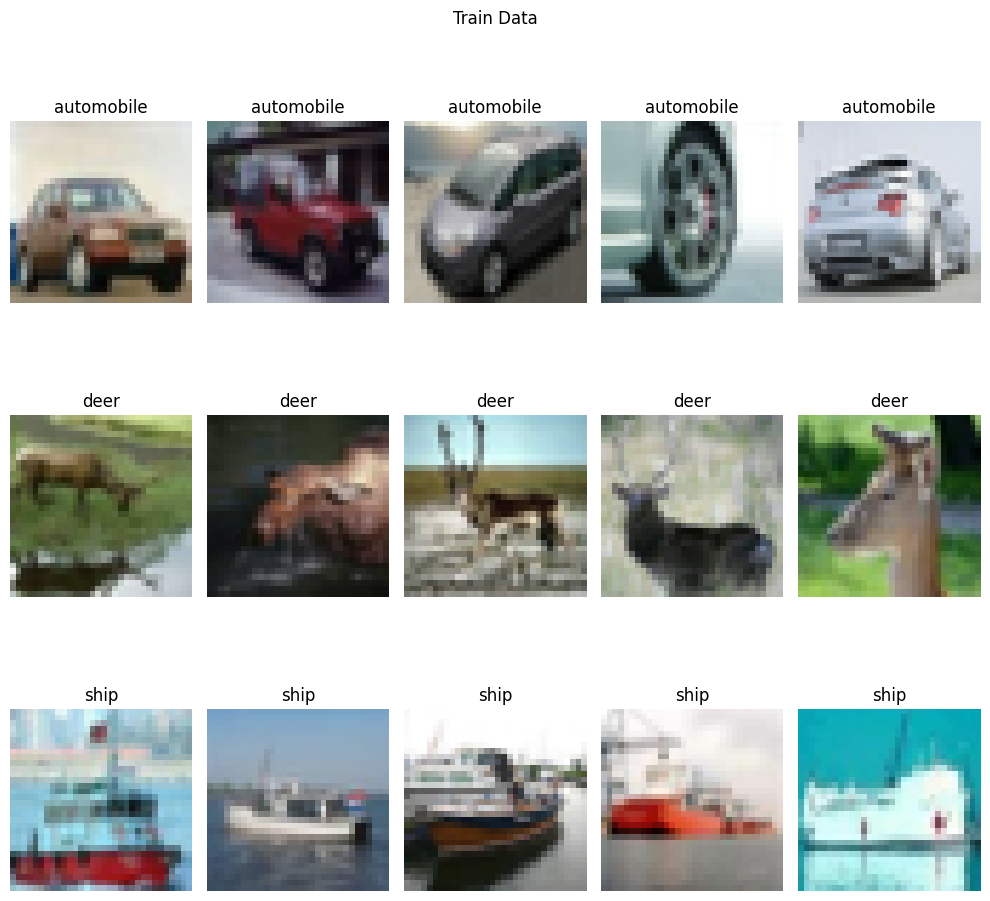

In [45]:
fig, ax = plt.subplots(3, 5, figsize=(10, 10))
for j, class_ in enumerate(np.unique(train_y)):
    for i in range(5):
        ax[j, i].imshow(train_X[train_y == class_][i])
        ax[j, i].set_title(cifar_train_data.classes[class_])
        ax[j, i].axis('off')
plt.suptitle('Train Data')
plt.tight_layout()
plt.show()

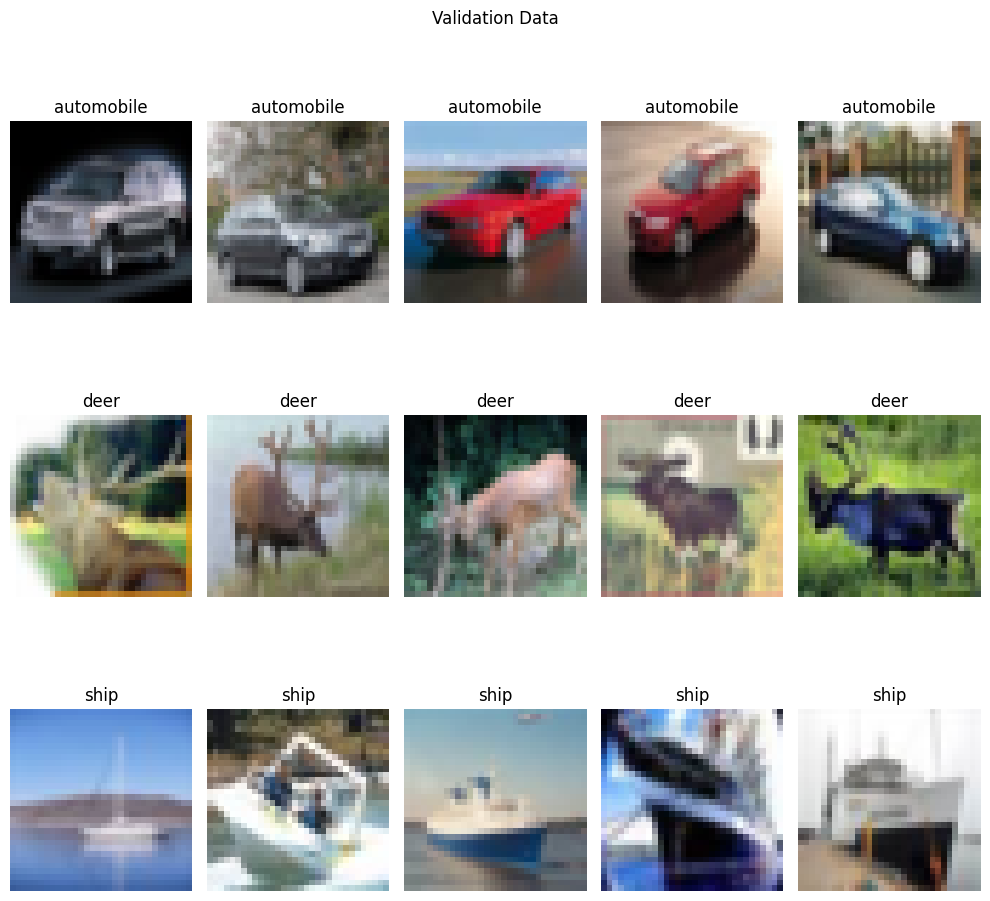

In [46]:
fig, ax = plt.subplots(3, 5, figsize=(10, 10))
for j, class_ in enumerate(np.unique(train_y)):
    for i in range(5):
        ax[j, i].imshow(val_X[val_y == class_][i])
        ax[j, i].set_title(cifar_train_data.classes[class_])
        ax[j, i].axis('off')
plt.suptitle('Validation Data')
plt.tight_layout()
plt.show()

#### Data preprocessing

In [47]:
transform = Compose([ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [48]:
class_map = {1: 0, 4: 1, 8: 2}
train_y = np.vectorize(class_map.get)(train_y)
val_y = np.vectorize(class_map.get)(val_y)
test_y = np.vectorize(class_map.get)(test_y)

In [49]:
train_dataset = CustomCIFAR(train_X, train_y, transform)
val_dataset = CustomCIFAR(val_X, val_y, transform)
test_dataset = CustomCIFAR(test_X, test_y, transform)

In [50]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

12000 3000 3000


#### Creating dataloaders for training, validation and testing

In [51]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
print(len(train_loader), len(val_loader), len(test_loader))

188 47 47


In [53]:
train_loader.dataset.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

#### CNN model
using ReLU activation function and `2` convolutional layers

Output size after a convolution:\
$ Output size = ((Input size + 2*padding - kernel size) / Stride) + 1 $

Output size after a max pooling:\
$ Output size = ((Input size - kernel size) / Stride) + 1 $

In [54]:
cnn = nn.Sequential()
# input (3, 32, 32)
cnn.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1, stride=1)) # output (16, 30, 30) 
cnn.add_module('relu1', nn.ReLU())
cnn.add_module('pool1', nn.MaxPool2d(kernel_size=(3,3), stride=2)) # output (16, 14, 14)

# input (16, 14, 14)
cnn.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=0, stride=1)) # outputs (32, 12, 12)
cnn.add_module('relu2', nn.ReLU())
cnn.add_module('pool2', nn.MaxPool2d(kernel_size=(3,3), stride=3))  # outputs (32, 4, 4)

# input (32, 4, 4)
cnn.add_module('flatten', nn.Flatten()) # outputs (512)

cnn.add_module('fc1', nn.Linear(in_features=512, out_features=16)) # outputs (16)
cnn.add_module('relu3', nn.ReLU())
cnn.add_module('fc2', nn.Linear(in_features=16, out_features=3)) # outputs (3)

In [55]:
cnn

Sequential(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

#### Training the model
using cross entropy loss and Adam optimizer

In [56]:
def train_neural_network(model, train_data, val_data, test_data, num_epochs=15, lr=0.01):
    np.random.seed(SEED)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    test_losses = []

    train_acc = []
    val_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_data:
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append((train_loss / len(train_data)))
        train_acc.append(correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        for imgs, labels in val_data:
            labels = labels.long()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_losses.append((val_loss / len(val_data)))
        val_acc.append(correct_val / total_val)

        # Testing
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        for imgs, labels in test_data:
            labels = labels.long()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_losses.append((test_loss / len(test_data)))
        test_acc.append(correct_test / total_test)

        print(
            f'Epoch {epoch + 1}/{num_epochs}',
            f'Train Loss: {train_losses[-1]:.4f}', 
            f'Val Loss: {val_losses[-1]:.4f}', 
            f'Test Acc: {test_acc[-1]:.4f}'
        )

    return train_losses, val_losses, test_losses, train_acc, val_acc, test_acc

In [57]:
cnn = cnn.to(torch.device('cpu'))
results = train_neural_network(cnn, train_loader, val_loader, test_loader, num_epochs=15, lr=0.001)

Epoch 1/15 Train Loss: 0.6536 Val Loss: 0.4686 Test Acc: 0.8163
Epoch 2/15 Train Loss: 0.4165 Val Loss: 0.3631 Test Acc: 0.8653
Epoch 3/15 Train Loss: 0.3432 Val Loss: 0.3453 Test Acc: 0.8720
Epoch 4/15 Train Loss: 0.3023 Val Loss: 0.2816 Test Acc: 0.9003
Epoch 5/15 Train Loss: 0.2766 Val Loss: 0.2787 Test Acc: 0.8997
Epoch 6/15 Train Loss: 0.2530 Val Loss: 0.3018 Test Acc: 0.8870
Epoch 7/15 Train Loss: 0.2376 Val Loss: 0.2436 Test Acc: 0.9127
Epoch 8/15 Train Loss: 0.2180 Val Loss: 0.2549 Test Acc: 0.9087
Epoch 9/15 Train Loss: 0.2094 Val Loss: 0.2287 Test Acc: 0.9197
Epoch 10/15 Train Loss: 0.2022 Val Loss: 0.2429 Test Acc: 0.9083
Epoch 11/15 Train Loss: 0.1859 Val Loss: 0.2118 Test Acc: 0.9240
Epoch 12/15 Train Loss: 0.1752 Val Loss: 0.2244 Test Acc: 0.9217
Epoch 13/15 Train Loss: 0.1734 Val Loss: 0.2045 Test Acc: 0.9250
Epoch 14/15 Train Loss: 0.1633 Val Loss: 0.2204 Test Acc: 0.9183
Epoch 15/15 Train Loss: 0.1568 Val Loss: 0.2021 Test Acc: 0.9290


Final accuracy on test set: `92.90%`

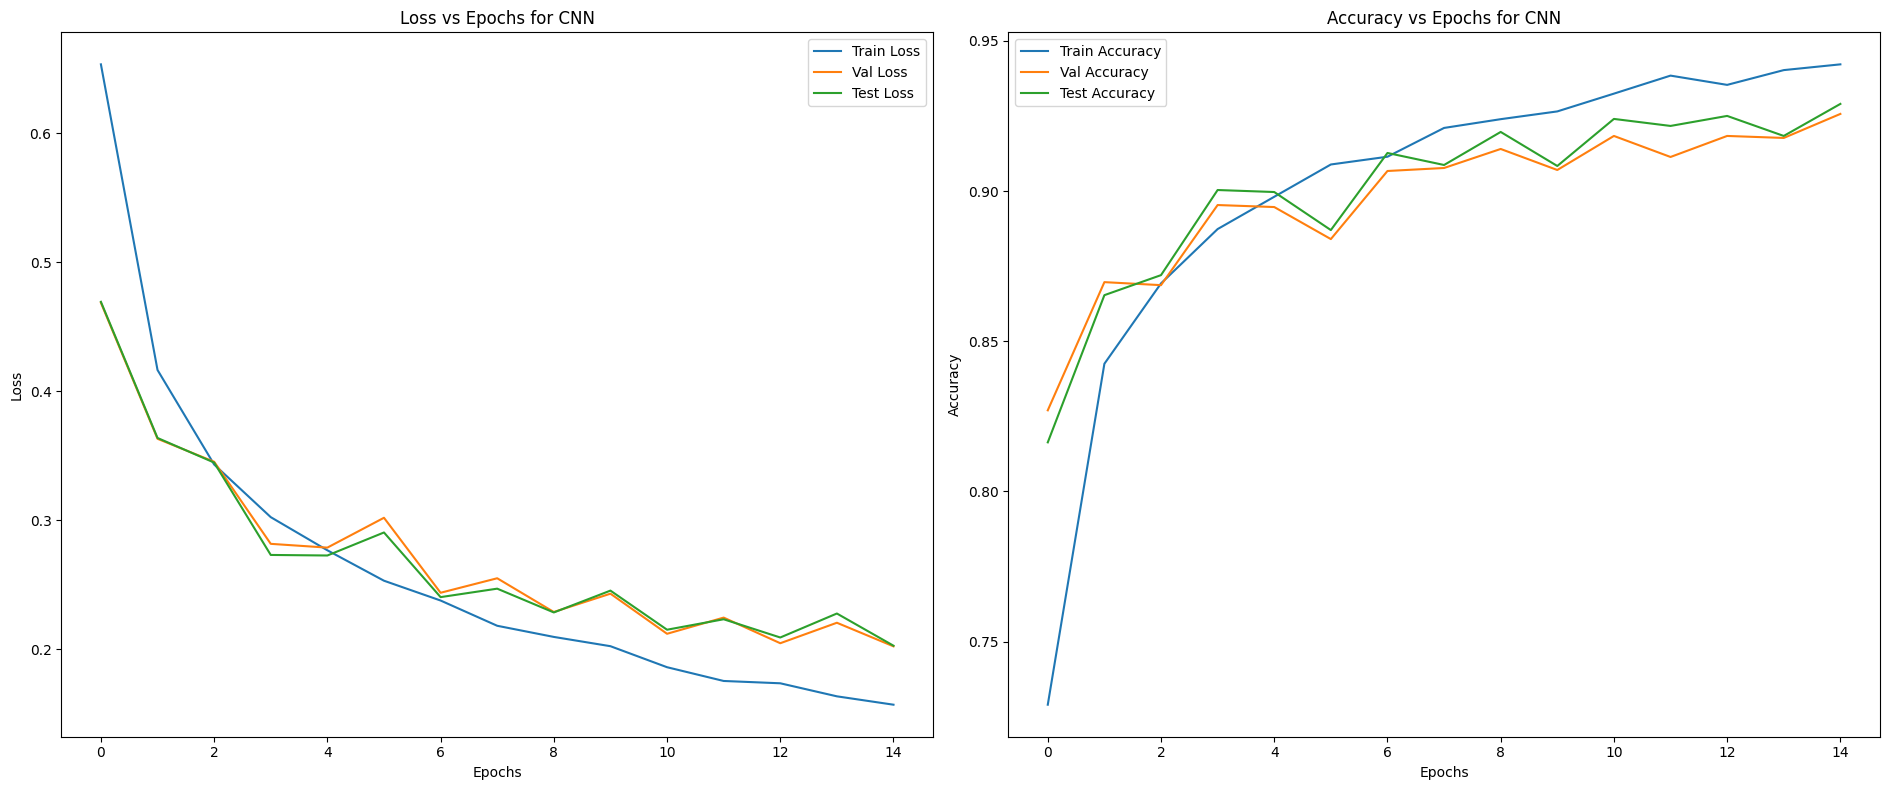

In [58]:
plt.figure(figsize=(19, 8))
plt.subplot(1, 2, 1)
plt.plot(results[0], label='Train Loss')
plt.plot(results[1], label='Val Loss')
plt.plot(results[2], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs for CNN')

plt.subplot(1, 2, 2)
plt.plot(results[3], label='Train Accuracy')
plt.plot(results[4], label='Val Accuracy')
plt.plot(results[5], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs for CNN')

plt.tight_layout()
plt.show()

We see that CNN model is able to learn the features of the images and classify them correctly with a good accuracy of `92.90%` for test set. The loss decreases with each epoch on the train set and subsequently the accuracies on validation and test set follow more or less a rising trend.

In [59]:
torch.save(cnn, 'cnn.pth')

#### Plotting the confusion matrix and reporting the accuracy and F1 score for train, validation and test set

In [60]:
def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, cm

In [61]:
train_accuracy, train_f1, train_cm = evaluate_model(cnn, train_loader)
val_accuracy, val_f1, val_cm = evaluate_model(cnn, val_loader)
test_accuracy, test_f1, test_cm = evaluate_model(cnn, test_loader)

In [62]:
print(f'Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation F1: {val_f1:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}%, Test F1: {test_f1:.2f}')

Train Accuracy: 95.50%, Train F1: 0.95
Validation Accuracy: 92.57%, Validation F1: 0.93
Test Accuracy: 92.90%, Test F1: 0.93


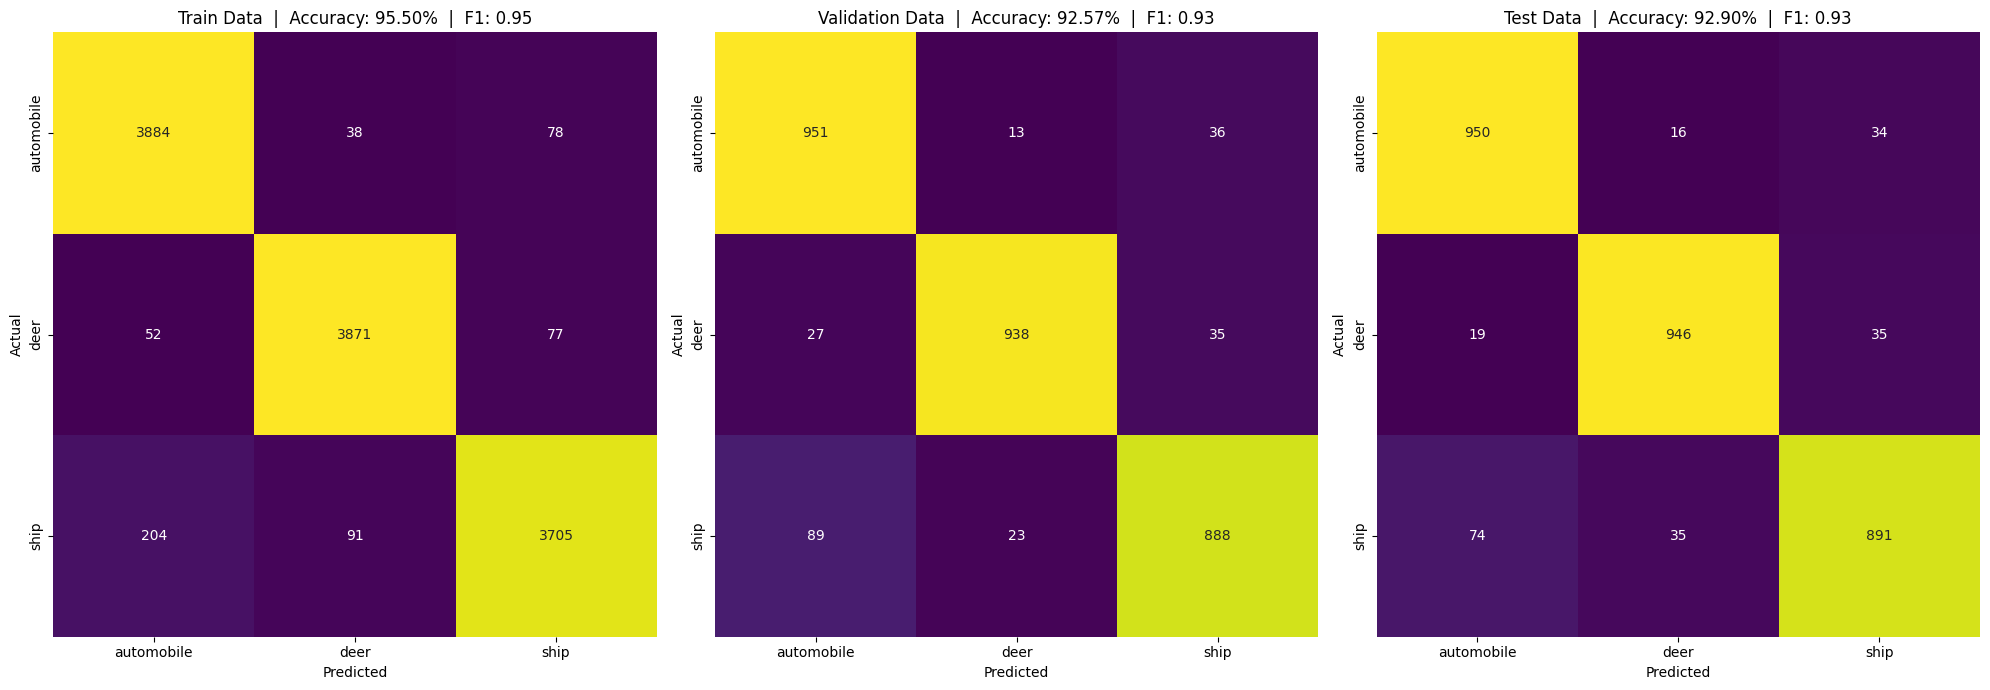

In [ ]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.title(f'Train Data  |  Accuracy: {train_accuracy:.2f}%  |  F1: {train_f1:.2f}')
sns.heatmap(train_cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])

plt.subplot(1, 3, 2)
plt.title(f'Validation Data  |  Accuracy: {val_accuracy:.2f}%  |  F1: {val_f1:.2f}')
sns.heatmap(val_cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])

plt.subplot(1, 3, 3)
plt.title(f'Test Data  |  Accuracy: {test_accuracy:.2f}%  |  F1: {test_f1:.2f}')
sns.heatmap(test_cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])


plt.tight_layout()
plt.show()

#### MLP model 
using ReLU activation function and `2` hidden layers

In [ ]:
mlp = nn.Sequential()
mlp.add_module('flatten', nn.Flatten()) # input (3, 32, 32) -> output (3*32*32)
mlp.add_module('fc1', nn.Linear(in_features=32*32*3, out_features=64)) # input (3*32*32) -> output (64)
mlp.add_module('relu1', nn.ReLU())
mlp.add_module('fc2', nn.Linear(in_features=64, out_features=3))  # input (64) -> output (3)

In [65]:
mlp

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [66]:
mlp = mlp.to(torch.device('cpu'))
results_mlp = train_neural_network(mlp, train_loader, val_loader, test_loader, num_epochs=15, lr=0.001)

Epoch 1/15 Train Loss: 0.6175 Val Loss: 0.5528 Test Acc: 0.7680
Epoch 2/15 Train Loss: 0.5061 Val Loss: 0.5012 Test Acc: 0.8077
Epoch 3/15 Train Loss: 0.4428 Val Loss: 0.4558 Test Acc: 0.8123
Epoch 4/15 Train Loss: 0.4020 Val Loss: 0.4558 Test Acc: 0.8223
Epoch 5/15 Train Loss: 0.3664 Val Loss: 0.4414 Test Acc: 0.8263
Epoch 6/15 Train Loss: 0.3293 Val Loss: 0.4693 Test Acc: 0.8140
Epoch 7/15 Train Loss: 0.3045 Val Loss: 0.4502 Test Acc: 0.8257
Epoch 8/15 Train Loss: 0.2807 Val Loss: 0.4471 Test Acc: 0.8260
Epoch 9/15 Train Loss: 0.2570 Val Loss: 0.5086 Test Acc: 0.8107
Epoch 10/15 Train Loss: 0.2282 Val Loss: 0.4736 Test Acc: 0.8210
Epoch 11/15 Train Loss: 0.2206 Val Loss: 0.4716 Test Acc: 0.8280
Epoch 12/15 Train Loss: 0.1873 Val Loss: 0.4943 Test Acc: 0.8237
Epoch 13/15 Train Loss: 0.1731 Val Loss: 0.4935 Test Acc: 0.8283
Epoch 14/15 Train Loss: 0.1526 Val Loss: 0.4895 Test Acc: 0.8283
Epoch 15/15 Train Loss: 0.1431 Val Loss: 0.5047 Test Acc: 0.8270


Final accuracy on test set: `82.70%`

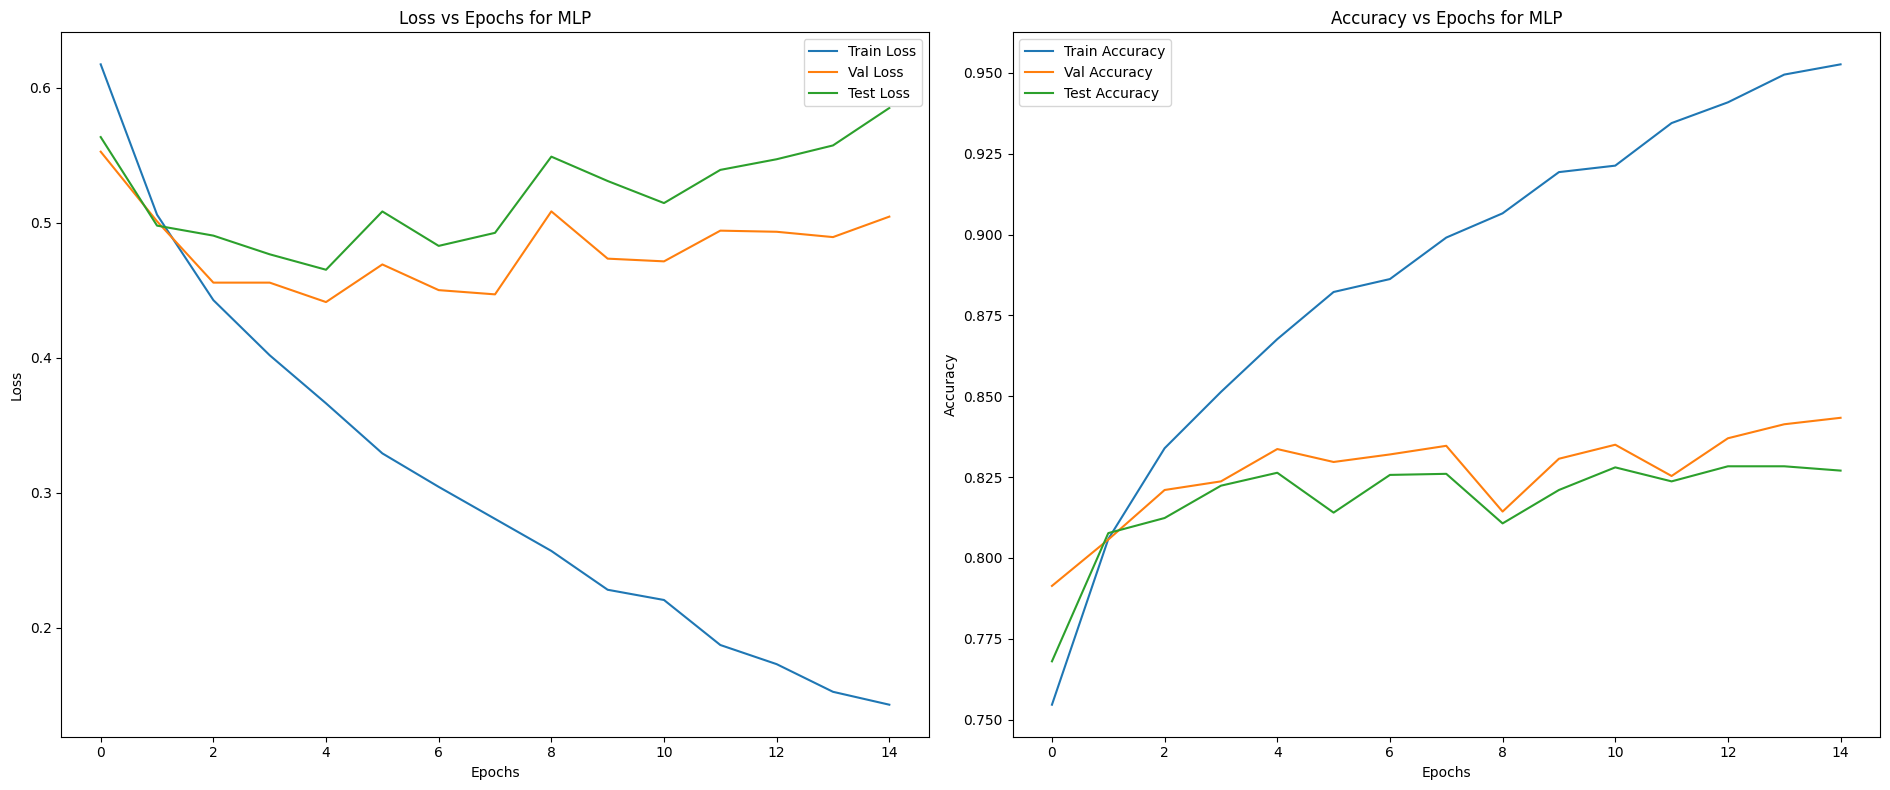

In [67]:
plt.figure(figsize=(19, 8))
plt.subplot(1, 2, 1)
plt.plot(results_mlp[0], label='Train Loss')
plt.plot(results_mlp[1], label='Val Loss')
plt.plot(results_mlp[2], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs for MLP')

plt.subplot(1, 2, 2)
plt.plot(results_mlp[3], label='Train Accuracy')
plt.plot(results_mlp[4], label='Val Accuracy')
plt.plot(results_mlp[5], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs for MLP')

plt.tight_layout()
plt.show()

We see that the MLP model provides an excellent accuracy on training set but overfits on the valdiation and train set as can be seen from the almost stable yet increasing trend of loss and decreasing trend of accuracy on validation and test set.

In [68]:
torch.save(mlp, 'mlp.pth')

#### Plotting the confusion matrix and reporting the accuracy and F1 score for train, validation and test set

In [69]:
train_accuracy, train_f1, train_cm = evaluate_model(mlp, train_loader)
val_accuracy, val_f1, val_cm = evaluate_model(mlp, val_loader)
test_accuracy, test_f1, test_cm = evaluate_model(mlp, test_loader)

In [70]:
print(f'Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation F1: {val_f1:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}%, Test F1: {test_f1:.2f}')

Train Accuracy: 96.97%, Train F1: 0.97
Validation Accuracy: 84.33%, Validation F1: 0.84
Test Accuracy: 82.70%, Test F1: 0.83


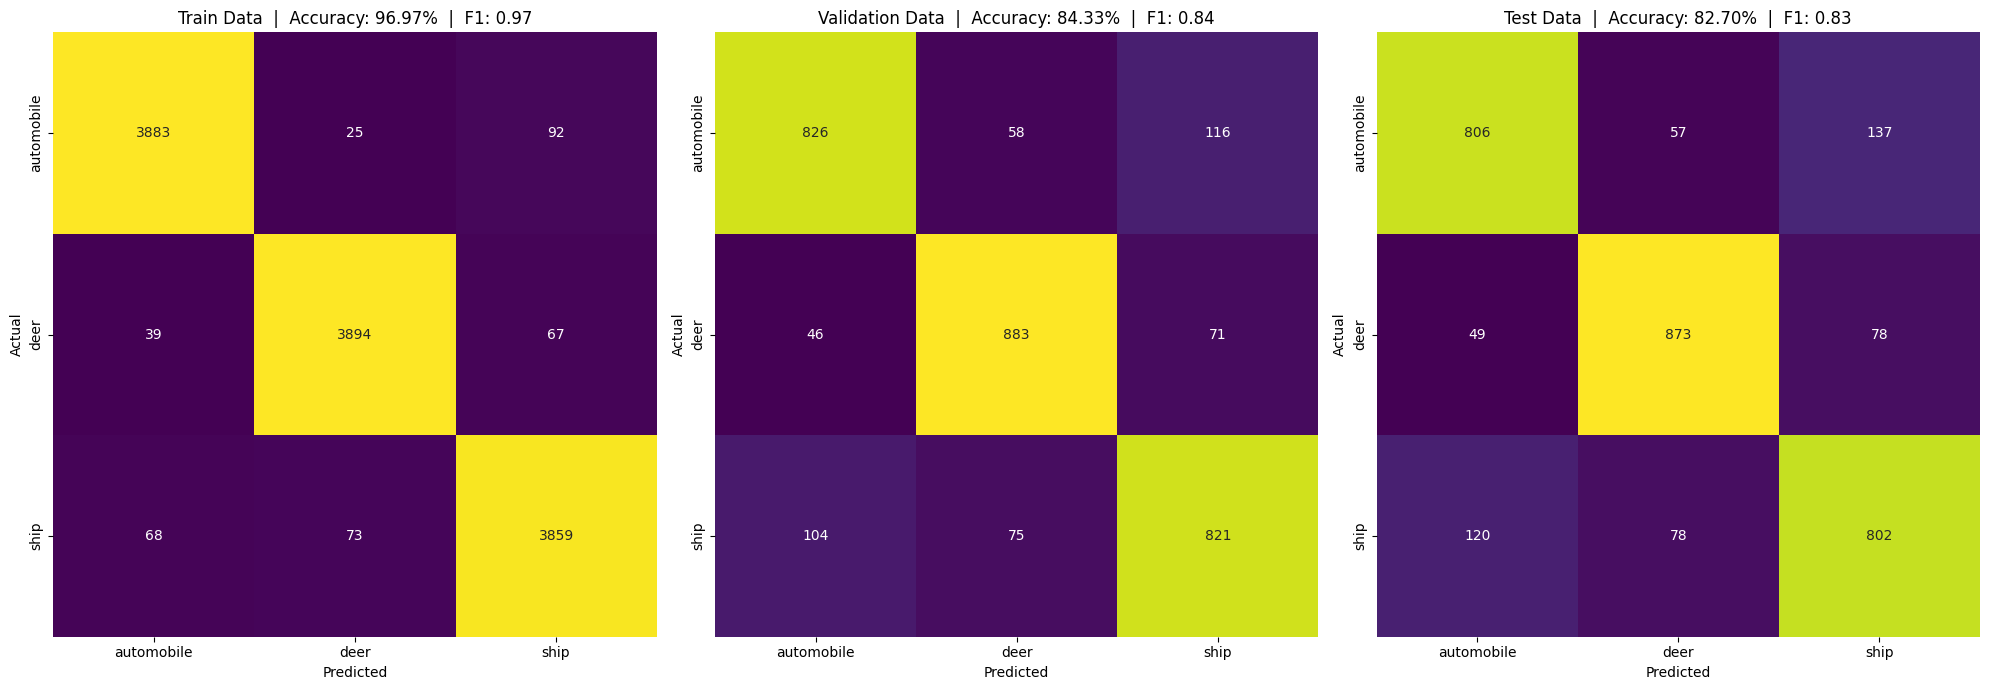

In [71]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.title(f'Train Data  |  Accuracy: {train_accuracy:.2f}%  |  F1: {train_f1:.2f}')
sns.heatmap(train_cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])

plt.subplot(1, 3, 2)
plt.title(f'Validation Data  |  Accuracy: {val_accuracy:.2f}%  |  F1: {val_f1:.2f}')
sns.heatmap(val_cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])

plt.subplot(1, 3, 3)
plt.title(f'Test Data  |  Accuracy: {test_accuracy:.2f}%  |  F1: {test_f1:.2f}')
sns.heatmap(test_cm, annot=True, fmt='d', cmap='viridis', cbar=False)   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])
plt.yticks([0.5, 1.5, 2.5], ['automobile', 'deer', 'ship'])

plt.tight_layout()
plt.show()

We see that our MLP model faced overfitting compared to CNN which worked well for our Image dataset.\
For an MLP compared to a CNN, overfitting can happen more easily for the following reasons:

1. Lack of Spatial Awareness in MLPs:\
MLPs treat the input as a flat vector and ignore the spatial structure of images (e.g., neighboring pixel relationships), making them require a much larger number of training samples for effective generalization. CNNs, on the other hand, use convolutional layers to capture spatial patterns (like edges, textures, etc.) and are thus more suited for image data.
2. Number of Parameters in MLP:\
Flattening an image like CIFAR-10 (`3` × `32` × `32`) results in a large number of input neurons (`3072`). This means the first layer of your MLP has `3072` × `64` parameters, which is already quite large. In contrast, CNNs use convolutional layers with shared weights (filters), significantly reducing the number of parameters. The larger parameter count in MLPs increases the likelihood of overfitting.
3. Model Complexity:\
CNNs inherently regularize the model by enforcing local connectivity and weight sharing, making them less prone to overfitting. MLPs, with fully connected layers, have a higher capacity to memorize training data due to their more flexible structure.
6. Difference in Feature Representations:\
CNNs automatically extract hierarchical features (edges, shapes, etc.), making them robust. MLPs, however, depend entirely on the input representation and may not capture meaningful features unless the dataset is sufficiently large and diverse.
